<a href="https://colab.research.google.com/github/ymuto0302/PJ2024/blob/main/GIS3_3_store_location_on_PRCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用(3-3)：平面直角座標系への店舗の配置  & 商圏設定
最終的に，店舗の商圏からどれほどの人口を獲得できるか（顧客の可能性があるか）を検討したい。

以下では，山口県の地理情報および店舗の位置が**緯度・経度で与えられることを前提として**，これらを平面直角座標系 (Plane Rectangular Coordinate System）へ投影できるか，を検証する。

---
### (準備) GeoPandas のインストール

In [1]:
!pip install geopandas

### (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
### (準備) 山口県の地理情報データを取得
ESRI Japan の提供する全国市区町村界データを利用する。

In [3]:
import geopandas as gpd

# 全国市区町村界データの読み込み
path = r'/content/drive/My Drive/BASE/GeoData/japan_ver84/japan_ver84.shp'
japan = gpd.read_file(path, encoding='shiftjis')

# 山口県のみ抽出
yamaguchi = japan[japan['KEN']=='山口県']

---
## 仮想的な店舗の配置 & 商圏の設定
最初に仮想的な店舗を１店のみ考え，思い通りの位置には配置できるか／思い通りに商圏を設定できるか，を確認する。

以下では，山口市の中心部（東経 131.5度，北緯 34.215度）に店舗を設置すると仮定する。

なお，座標系 (CRS) として "EPSG:4612" を指定することに注意する。

### 店舗の配置
以下では，店舗の位置情報に加えて，店舗名（この例では "storeA"）を設定する。

In [4]:
# 店舗の定義
import geopandas as gpd
from shapely.geometry import Point

# 北緯 34.215度，東経 131.5度に店舗を設置する
store = gpd.GeoDataFrame([['storeA', Point(131.5, 34.215)]],
                         columns=['name', 'geometry'],
                         crs='EPSG:4612')

# 変数 store の確認
store

,name,geometry
0,storeA,POINT (131.50000 34.21500)


変数 `store` を山口県の地図と併せて可視化すると，山口市の中心部に点が打たれることが分かる。

<Axes: >

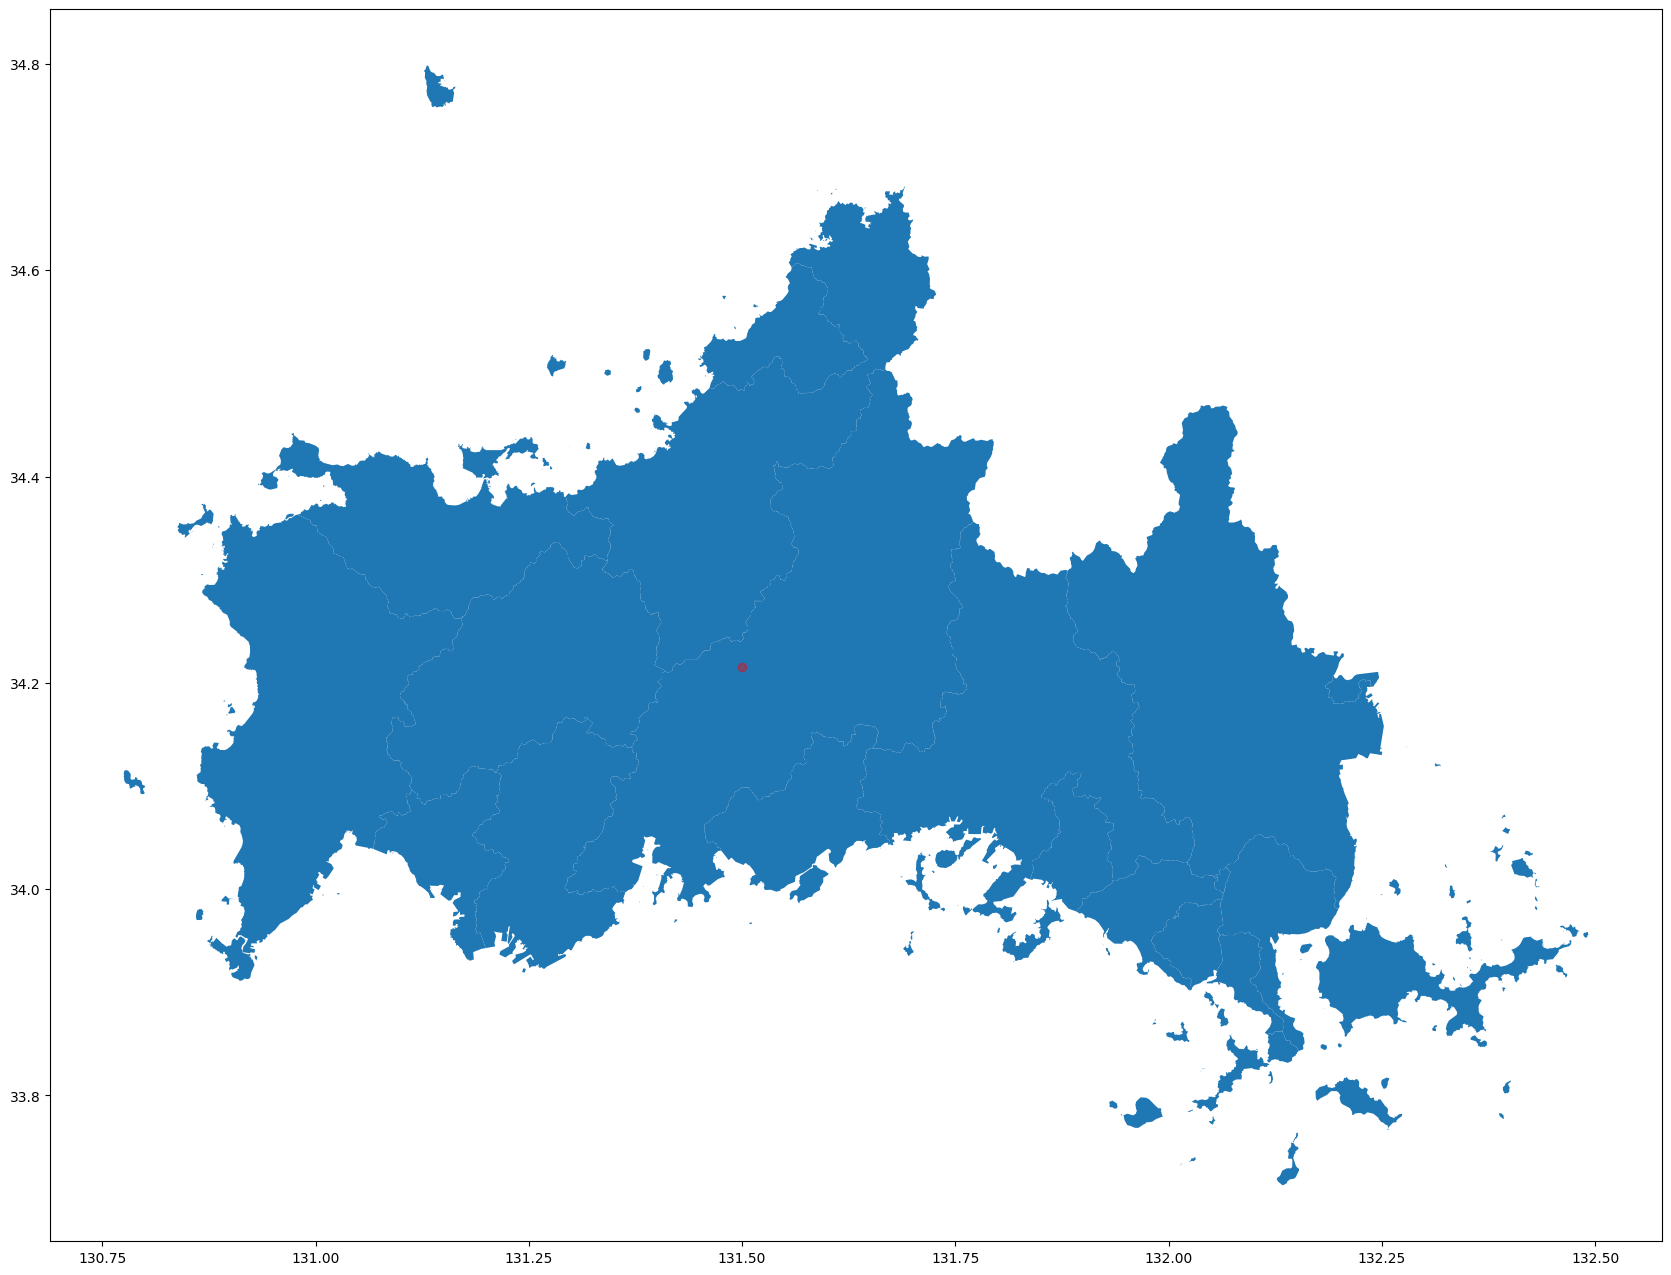

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(32, 16))
yamaguchi.plot(ax=ax)
store.plot(ax=ax, color="red", alpha=0.4)

### 商圏の定義
次に「東経 131.5度，北緯 34.215度」を中心とした，半径 5km の円 "market_area" を生成する。

ここで緯度・経度とメートル法が混在しているため，全てをメートル法へ変換する。

手順は以下のとおり：
1. 店舗 `store' の位置を平面直角座標系へ変換した結果を `market_area` を生成する。
1. `buffer()` メソッドを利用して，`market_area` の `geometry` を再設定する。ここで `buffer()` メソッドへ与える半径はメートル単位であるため，5,000 を設定すること。

In [6]:
# 店舗位置を平面直角座標系へ変換
# ただし，後の buffer() のため，変数名を market_area へ変更
market_area = store.to_crs('EPSG:2443', inplace=False) #  平面直角座標系へ変換

# Point(131.5, 34.215) を中心に半径 5000[m] = 5[km] の円をポリゴンとして生成
buffer_size = 5000 # バッファサイズの指定
market_area['geometry'] = market_area.buffer(buffer_size) # 半径 5[km]の円を生成

market_area

,name,geometry
0,storeA,"POLYGON ((189298.206 136557.792, 189274.129 13..."


In [7]:
# (参考) 生成した商圏の CRS を確認すると，EPSG:2443 が用いられている。
market_area.crs

<Projected CRS: EPSG:2443>
Name: JGD2000 / Japan Plane Rectangular CS I
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Japan - onshore - Kyushu west of approximately 130°E - Nagasaki-ken; islands of Kagoshima-ken between 27°N and 32°N and between 128°18'E and 130°E (between 128°18'E and 30°13'E for Amami islands).
- bounds: (128.17, 26.96, 130.46, 34.74)
Coordinate Operation:
- name: Japan Plane Rectangular CS zone I
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

山口県の地図上で，商圏を可視化する。

手順は以下のとおり；
1. 変数 `yamaguchi` では緯度・経度が使用されているため，予め平面直角座標系へ変換する。
1. その後，`ax` を利用して，山口県の地図と商圏を重ねる。

<Axes: >

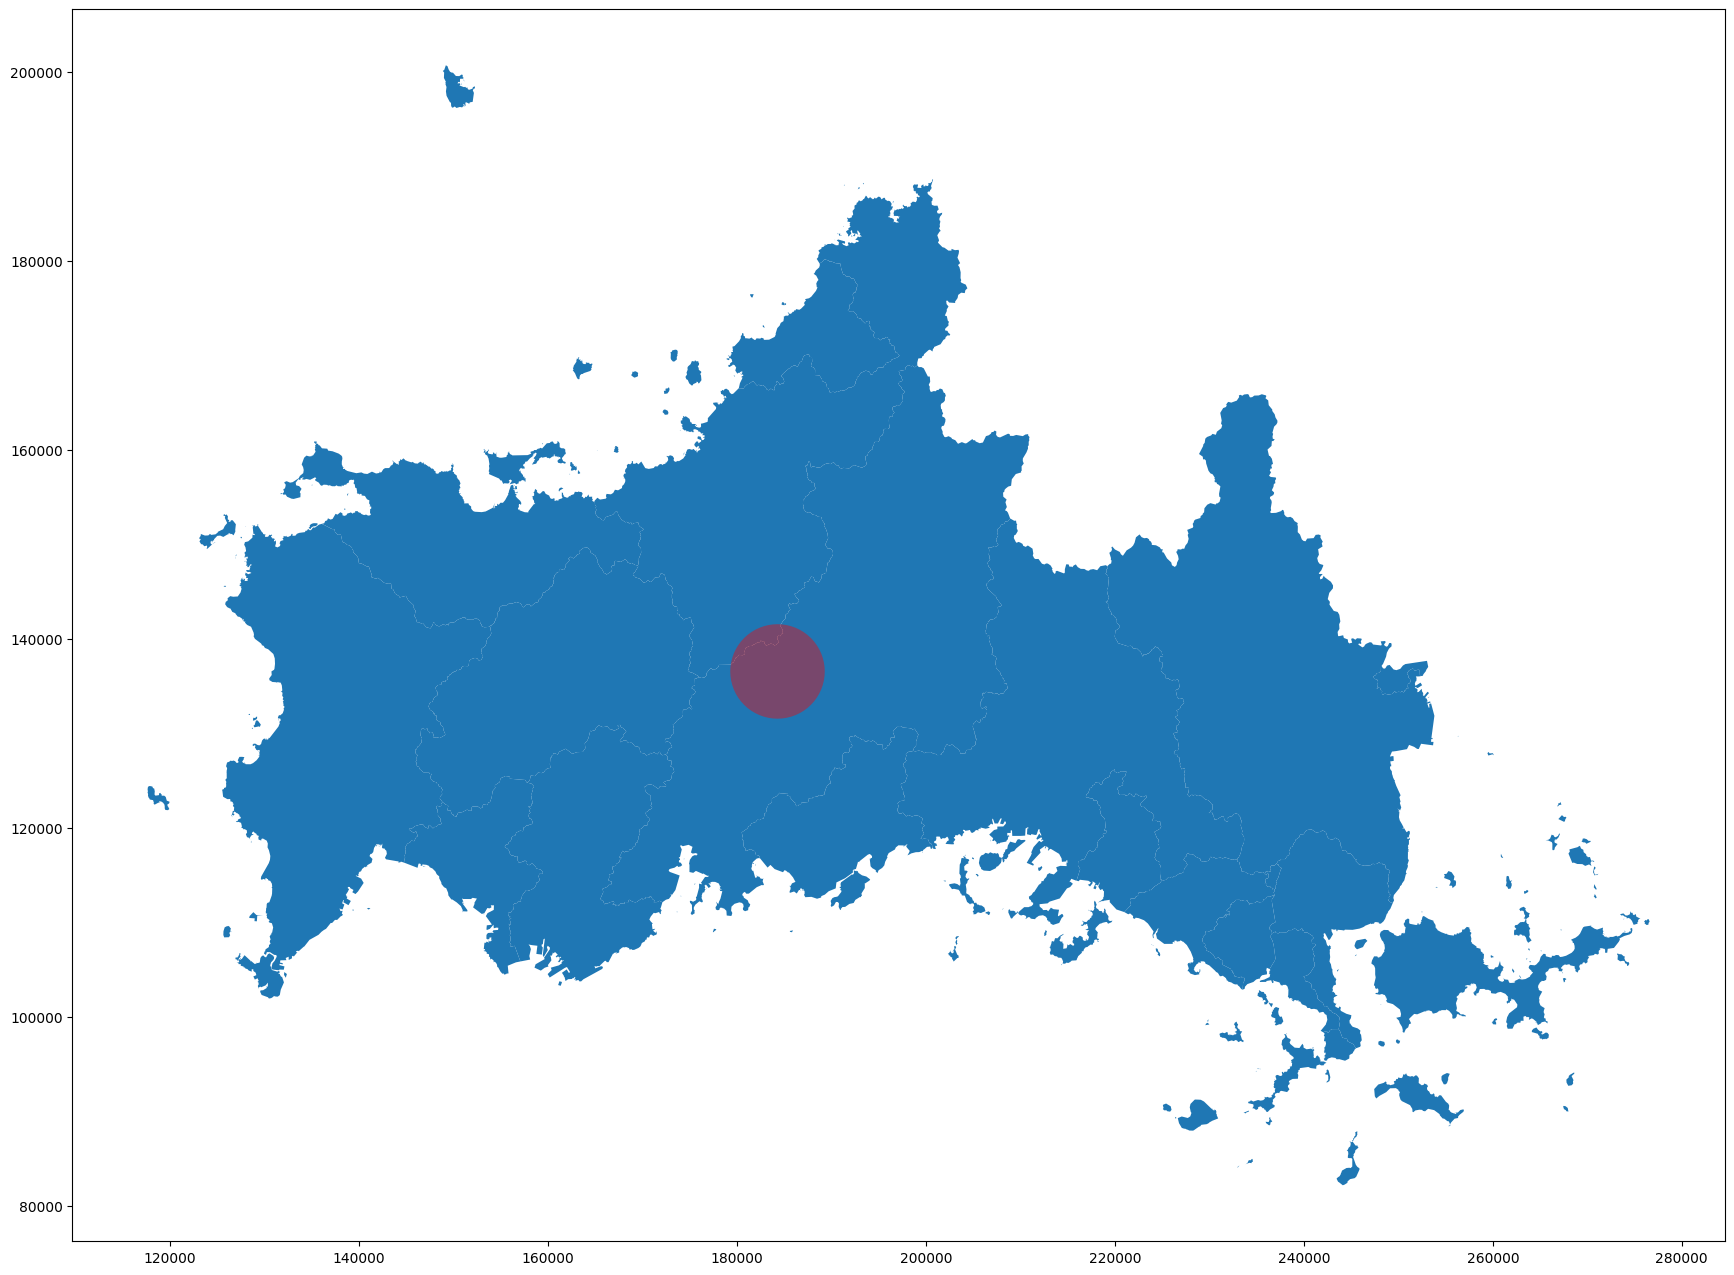

In [8]:
# 商圏の可視化
import matplotlib.pyplot as plt

# 山口県データの座標系を平面直角座標系へ変換
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# 投影された山口県データと商圏を重ねて表示
fig, ax = plt.subplots(1, figsize=(32, 16))
projected_yamaguchi.plot(ax=ax)
market_area.plot(ax=ax, color="red", alpha=0.4)

---
## 現実の店舗の配置
山口県内で展開しているスーパー・チェーン「まるき」（株式会社 丸喜）を取り上げる。

予め以下のサイトから「まるき」の各店舗の住所を調べ，ジオコーディングサービスを用いて住所を緯度・経度情報へ変換した。その集計結果をファイル "maruki.xlsx" に格納した。

参考にしたサイトは以下のとおり：
- まるきの店舗一覧：http://marukijapan.co.jp/shops/shoplist/
- Geocoding - 住所から緯度経度を検索：https://www.geocoding.jp/

In [9]:
import pandas as pd
maruki = pd.read_excel('/content/drive/My Drive/BASE/GeoData/maruki.xlsx')

In [10]:
maruki.head()

,市名,店舗名,住所,緯度,経度
0,防府市,ウェスタまるき華城店,山口県防府市華園町12番31号,34.042948,131.556828
1,山口市,ウェスタまるき山口湯田店,山口市幸町584番地,34.158491,131.449315
2,山口市,まるき山口嘉川店,山口市大字江崎字和井田2703番1,34.058814,131.367455
3,山口市,ウェスタまるき山口宮野店,山口市大字宮野上字長登路1804番1,34.207288,131.513980
4,山口市,ウェスタまるき山口大内店,山口市大内千坊五丁目４番１２号,34.155754,131.492651


次に，全ての「まるき」の店舗位置を GeoDataFrame へ変換する。

In [11]:
# 店舗群の定義
from shapely.geometry import Point

# [[店舗名A, Point(経度A,緯度A)], [店舗名B, Point(経度B,緯度B)], [店舗名C, Point(経度C,緯度C)]] の形のリストを作る
number_of_store = len(maruki) # 店舗数
store_list = list()
for idx in range(number_of_store):
    data = maruki.iloc[idx]
    # (注意) Point の引数は (経度, 緯度)
    store_list.append([data['店舗名'], Point(data['経度'], data['緯度'])])

# リストから GeoDataFrame への変換
# ここでは CRS として "EPSG:4612" (緯度・経度の座標系を指定)
stores = gpd.GeoDataFrame(store_list,
                         columns=['name', 'geometry'], crs='EPSG:4612')

In [12]:
# 変数 stores の中身を確認
stores.head()

,name,geometry
0,ウェスタまるき華城店,POINT (131.55683 34.04295)
1,ウェスタまるき山口湯田店,POINT (131.44932 34.15849)
2,まるき山口嘉川店,POINT (131.36746 34.05881)
3,ウェスタまるき山口宮野店,POINT (131.51398 34.20729)
4,ウェスタまるき山口大内店,POINT (131.49265 34.15575)


次に，平面直角座標系（メートル法）へ変換するため， `to_crs()` メソッドを用いる。
加えて，半径3kmの証券を設定する。

In [13]:
# 投影座標系の変換
# GeoDataFrame "stores" に複数の店舗情報が含まれている場合でも一括変換してくれる
market_areas = stores.to_crs('EPSG:2443', inplace=False)

# 商圏の設定：半径 buffer_size のポリゴンを生成
buffer_size = 3000 # 半径 3000[m] = 3[km]
market_areas['geometry'] = market_areas.buffer(buffer_size)

In [14]:
# 変数 market_areas の中身を確認
market_areas.head()

,name,geometry
0,ウェスタまるき華城店,"POLYGON ((192920.287 117574.595, 192905.841 11..."
1,ウェスタまるき山口湯田店,"POLYGON ((182746.841 130198.206, 182732.396 12..."
2,まるき山口嘉川店,"POLYGON ((175399.667 118999.270, 175385.221 11..."
3,ウェスタまるき山口宮野店,"POLYGON ((188603.562 135727.607, 188589.116 13..."
4,ウェスタまるき山口大内店,"POLYGON ((186749.390 129971.791, 186734.944 12..."


最後に商圏を（メートル法で表現された）山口県の地理情報データに重ねる。

<Axes: >

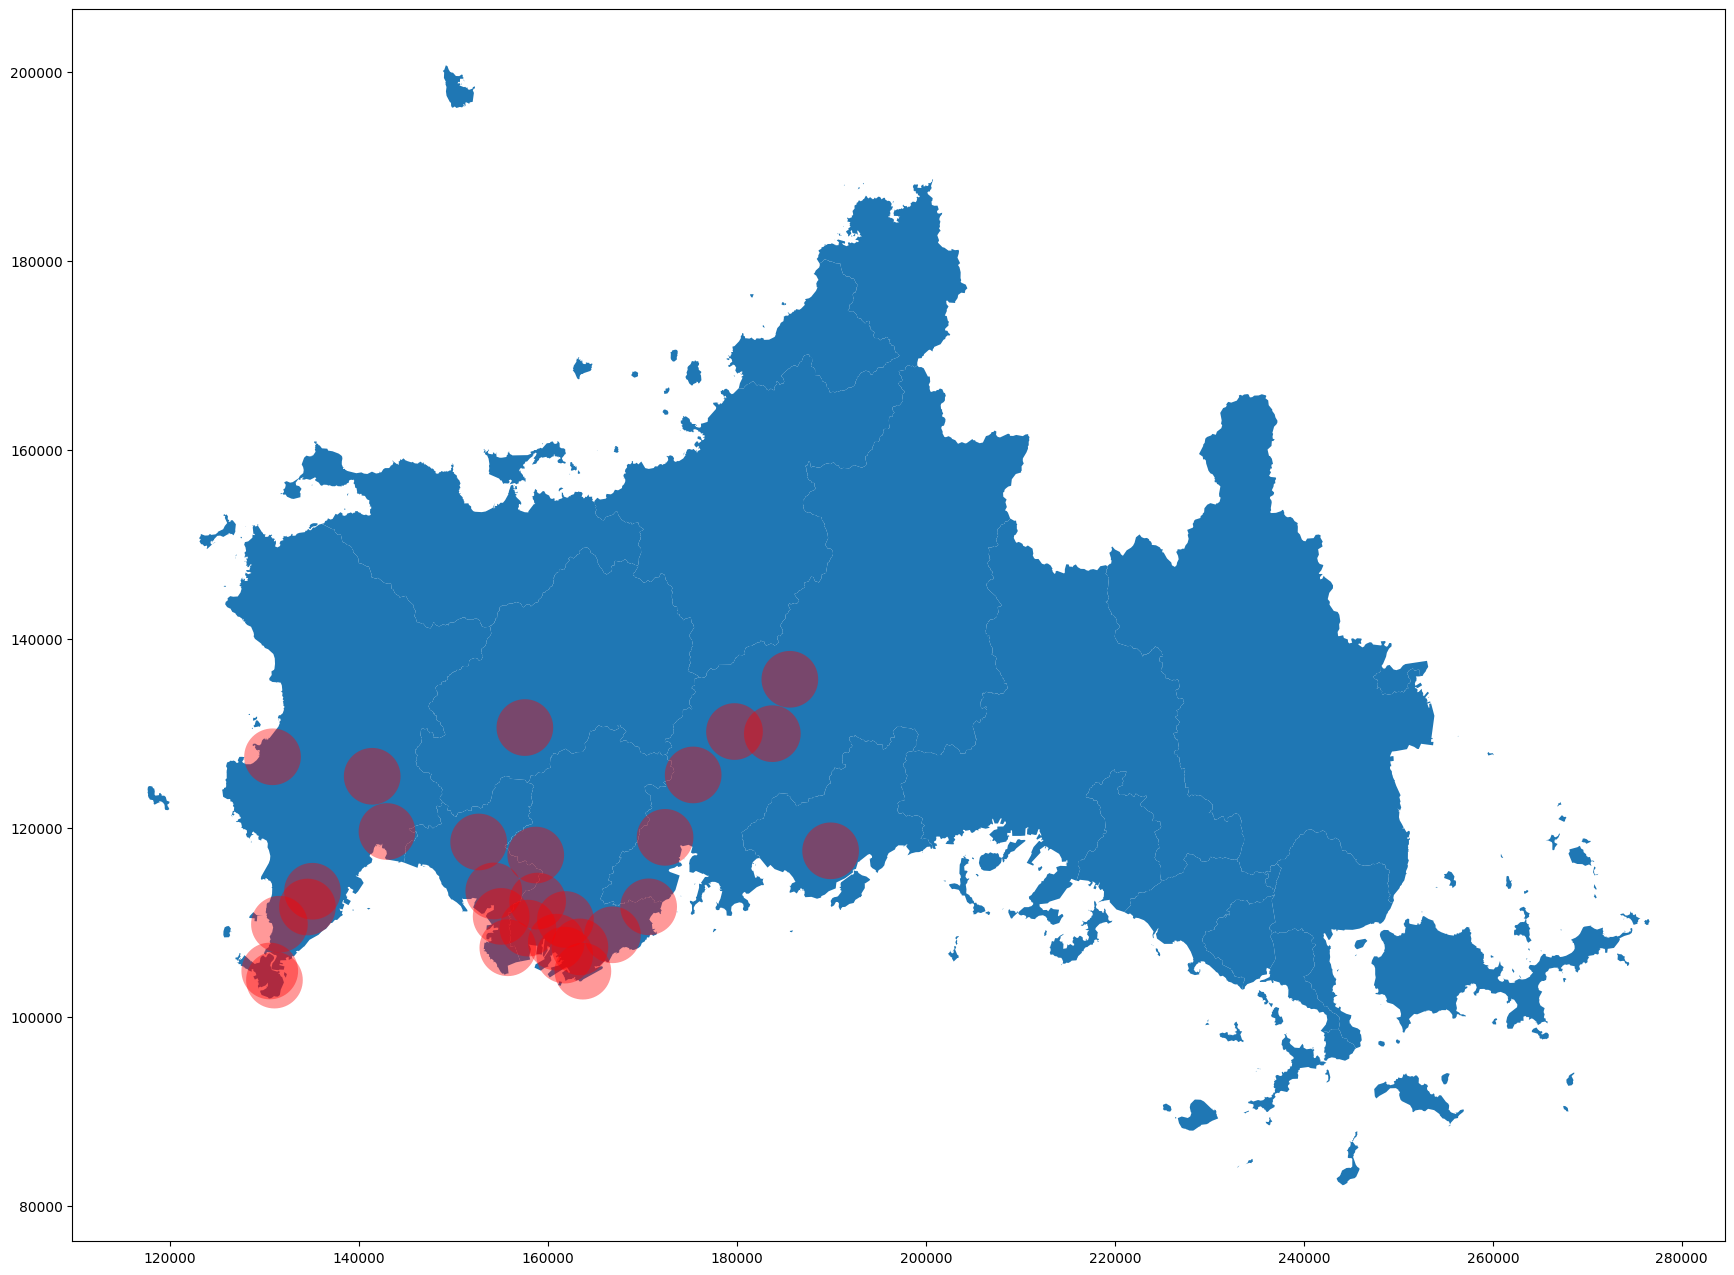

In [15]:
# 商圏の可視化
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(32, 16))
projected_yamaguchi.plot(ax=ax)
market_areas.plot(ax=ax, color="red", alpha=0.4)